In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score

from sklearn.decomposition import NMF
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

from sklearn.decomposition import TruncatedSVD


# Flowers Dataset and VGG Features

![image.png](attachment:image.png)

In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


In [ ]:
np.count_nonzero(f_all)

15032320

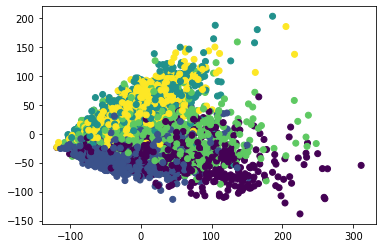

In [ ]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

# Autoencoder

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


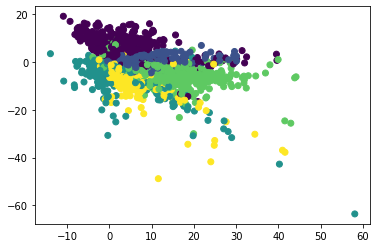

In [ ]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

### Question 23

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


tsne graph


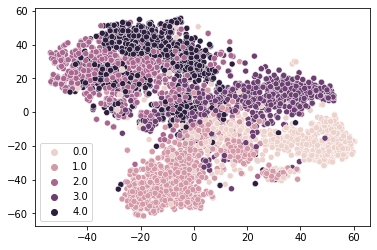

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, init='random').fit_transform(f_all)
sns.scatterplot(tsne[:,0], tsne[:,1], hue=y_all)
print('tsne graph')

### Question 24

In [ ]:
pip install umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=35d21101ee6cad92266e2db9a354942b4efb173ed8c91e9a6e14d41e66705a9f
  Stored in directory: /root/.cache/pip/wheels/d4/13/91/2e752dc8dab5df027854bd33d2b65e1dc5cdc107fd1133990f
Successfully built umap


In [ ]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=91bae8be6f862db79448bc50f94ab6e9c5fb1f642134e0d8a4e737aa72b77d61
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=3d721ae6164b1fe20d69d52e1e01b934822c03c0ce21a8c533273126d0266e5a
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [ ]:
pip install umap-learn[plot]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 KB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59439 sha256=63dc0c57787046d4e61dcd1592c281384baca80a907d41bedf8a43256d15d87d
  Stored in directory: /root/.cache/pip/wheels/6d/79/c4/c425774559165f472d32e5ef592ff9a71179abb31f05dbc98b
Successfully built datashape


In [ ]:
import umap.umap_ as umap
import umap.plot

In [ ]:
#dimensional reduction

# svd
svd50 = TruncatedSVD(n_components=50,random_state = 42)
svd_trans50 = svd50.fit_transform(f_all)

# umap
umap50 = umap.UMAP(n_components=50, metric="cosine")
umap_trans50 = umap50.fit_transform(f_all)

# autoencoder
X_em_50 =Autoencoder(50).fit_transform(f_all)

100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


In [ ]:
dimensional_reductions = [f_all, svd_trans50, umap_trans50, X_em_50]
dimensional_reductions_names = ["no dimensional reductions",
                                "svd(r=50)", 
                                "umap(n_components=50)",
                                'autoencoder(50)'
                                ]

In [ ]:
pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 70.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=3773989 sha256=2ea4404a20aa945bef63fffb355b7b85ee56311a86728b672e4d2109be4228c8
  Stored in directory: /root/.cache/pip/wheels/76/06/48/527e038689c581cc9e519c73840efdc7473805149e55bd7ffd
Successfully built hdbscan


In [ ]:
def five_metrics(y, y_pred):
    return (homogeneity_score(y, y_pred), completeness_score(y, y_pred), v_measure_score(y, y_pred), 
            adjusted_rand_score(y, y_pred), adjusted_mutual_info_score(y, y_pred))

In [ ]:
# clustering
from sklearn.cluster import AgglomerativeClustering
import hdbscan

# hyperparameter
k = [5]
n_clusters = [5]
min_cluster_size = [100, 200]
min_sample = [None, 1, 5]

#models
scores = {}

#kmeans
for i in k:
    kmeans = KMeans(n_clusters=i, n_init = 30, max_iter = 1000, random_state=0)
    for d in range(len(dimensional_reductions)):
        kmeans.fit(dimensional_reductions[d])
        temp_metrics = five_metrics(y_all, kmeans.labels_)
        scores['Kmeans with ' + dimensional_reductions_names[d]] = temp_metrics

# Agglomerative Clustering
for i in n_clusters:
    ac = AgglomerativeClustering(n_clusters = i)
    for d in range(len(dimensional_reductions)):
        ac.fit(dimensional_reductions[d])
        temp_metrics = five_metrics(y_all, ac.labels_)
        scores['Agglomerative clustering with ' + dimensional_reductions_names[d]] = temp_metrics

# HDBSCAN
for i in min_cluster_size:
    for j in min_sample:
        hdb = hdbscan.HDBSCAN(min_cluster_size = i, min_samples = j)
        for d in range(len(dimensional_reductions)):
            hdb.fit(dimensional_reductions[d])
            temp_metrics = five_metrics(y_all, hdb.labels_)
            scores['HDBSCAN' + 'min_cluster_size' + str(i) + 'min_samples' + str(j) + 'with'  + dimensional_reductions_names[d]] = temp_metrics

In [ ]:
scores

{'Kmeans with no dimensional reductions': (0.3355153113938533,
  0.3722337766176792,
  0.35292205553829165,
  0.19423398949790877,
  0.35199138907914684),
 'Kmeans with svd(r=50)': (0.32506016374942187,
  0.35962182606431964,
  0.3414686859227437,
  0.1912735929354897,
  0.34052282982639837),
 'Kmeans with umap(n_components=50)': (0.5314994137830374,
  0.5431495371911339,
  0.5372613267838274,
  0.4672148413331576,
  0.5366220745823465),
 'Kmeans with autoencoder(50)': (0.300442285374471,
  0.3276473568796156,
  0.31345564096404627,
  0.20313860176365867,
  0.3124761084467751),
 'Agglomerative clustering with no dimensional reductions': (0.357423727296284,
  0.41402546658906453,
  0.3836481433561248,
  0.18855278251971858,
  0.3827433388813023),
 'Agglomerative clustering with svd(r=50)': (0.3291520517853487,
  0.40497567318180605,
  0.3631481803984671,
  0.1441474250358487,
  0.36218692922530765),
 'Agglomerative clustering with umap(n_components=50)': (0.514443982037259,
  0.53753108

In [ ]:
print("The Best Result is Agglomerative clustering with umap(n_components=50)")

The Best Result is Agglomerative clustering with umap(n_components=50)


### Question 25

# MLP Classifier

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, y_.cuda())
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                ## Same as Autoencoder function

        return self
    
    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        x_pred = self(torch.tensor(X_test, dtype=torch.float32, device='cuda'))
        top_pred = x_pred.argmax(dim=1)
        y_i = torch.tensor(y_test, dtype=torch.float32, device='cuda')
        correct = top_pred.eq(y_i).sum()
        acc = correct / X_test.shape[0]
        return acc

#Reference:https://github.com/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)
model = MLP(4096)
model.train(X_train, y_train)
acc = model.eval(X_test, y_test)
print("Accuracy:", acc)
     

100%|██████████| 100/100 [00:11<00:00,  8.35it/s]

Accuracy: tensor(0.8937, device='cuda:0')


In [ ]:
# umap + mlp
r = [5, 10, 50, 100]
accuracy = []
for i in r:
    umap1 = umap.UMAP(n_components=i, metric="cosine")
    umap_trans1 = umap1.fit_transform(f_all)
    model = MLP(i)
    X_train, X_test, y_train, y_test = train_test_split(umap_trans1, y_all, test_size=0.2, random_state=42)
    model.train(X_train, y_train)
    accuracy.append(model.eval(X_test, y_test))

100%|██████████| 100/100 [00:06<00:00, 14.75it/s]


In [ ]:
accuracy

[tensor(0.8542, device='cuda:0'),
 tensor(0.8542, device='cuda:0'),
 tensor(0.8311, device='cuda:0'),
 tensor(0.8243, device='cuda:0')]

In [ ]:
print("The Accuracy of MLP with umap(n_components = 5):", accuracy[0])
print("The Accuracy of MLP with umap(n_components = 10):", accuracy[1])
print("The Accuracy of MLP with umap(n_components = 50):", accuracy[2])
print("The Accuracy of MLP with umap(n_components = 100):", accuracy[3])

The Accuracy of MLP with umap(n_components = 5): tensor(0.8542, device='cuda:0')
The Accuracy of MLP with umap(n_components = 10): tensor(0.8542, device='cuda:0')
The Accuracy of MLP with umap(n_components = 50): tensor(0.8311, device='cuda:0')
The Accuracy of MLP with umap(n_components = 100): tensor(0.8243, device='cuda:0')
